In [1]:
using DrWatson

In [2]:
quickactivate(@__DIR__)

In [3]:
projectdir()

"/home/tor/Projects/mine/Covid19"

In [4]:
using Covid19

┌ Info: Precompiling Covid19 [1d6b4b23-2965-494f-a811-b0912eb134ac]
└ @ Base loading.jl:1260


In [5]:
using Turing

# Load data

In [6]:
using RData

In [7]:
import DrWatson: datadir

datadir() = projectdir("data", "imperial-report13")
datadir(s...) = projectdir("data", "imperial-report13", s...)

datadir (generic function with 2 methods)

In [8]:
datadir()

"/home/tor/Projects/mine/Covid19/data/imperial-report13"

In [9]:
rdata = load(datadir("processed.rds"));

┌ Warning: Unsupported AltRep SEXP
└ @ RData /home/tor/.julia/packages/RData/7cjT6/src/convert.jl:205


## Make data a bit more convenient to work with

In [10]:
countries = (
  "Denmark",
  "Italy",
  "Germany",
  "Spain",
  "United_Kingdom",
  "France",
  "Norway",
  "Belgium",
  "Austria", 
  "Sweden",
  "Switzerland",
  "Greece",
  "Portugal",
  "Netherlands"
)
num_countries = length(countries)

# TODO: not sure if either of the below is the correct ordering of the names!
# names_covariates = (
#     "Schools + Universities",
#     "Self-isolating if ill",
#     "Public events",
#     "Lockdown",
#     "Social distancing encouraged"
# )
names_covariates = ("schools_universities", "self_isolating_if_ill", "public_events", "any", "lockdown", "social_distancing_encouraged")

function rename!(d, names::Pair...)
    # check that keys are not yet present before updating `d`
    for k_new in values.(names)
        @assert k_new ∉ keys(d) "$(k_new) already in dictionary"
    end
    
    for (k_old, k_new) in names
        d[k_new] = pop!(d, k_old)
    end
    return d
end


rename! (generic function with 1 method)

In [11]:
# `rdata` is a `DictOfVector` so we convert to a simple `Dict` for simplicity
d = Dict([(k, rdata[k]) for k in keys(rdata)]) # `values(df)` and `keys(df)` have different ordering so DON'T do `Dict(keys(df), values(df))`

# Rename some columns
rename!(
    d,
    "f" => "π", "SI" => "serial_intervals", "pop" => "population",
    "M" => "num_countries", "N0" => "num_impute", "N" => "num_obs_countries",
    "N2" => "num_total_days", "EpidemicStart" => "epidemic_start"
)

# Add some type-information to arrays and replace `-1` with `missing` (as `-1` is supposed to represent, well, missing data)
d["deaths"] = Int.(d["deaths"])
d["deaths"] = replace(d["deaths"], -1 => missing)
d["deaths"] = collect(eachcol(d["deaths"])) # convert into Array of arrays instead of matrix

d["cases"] = Int.(d["cases"])
d["cases"] = replace(d["cases"], -1 => missing)
d["cases"] = collect(eachcol(d["cases"])) # convert into Array of arrays instead of matrix

d["num_total_days"] = Int(d["num_total_days"])
d["num_impute"] = Int(d["num_impute"])
d["num_obs_countries"] = Int.(d["num_obs_countries"])
d["epidemic_start"] = Int.(d["epidemic_start"])
d["population"] = Int.(d["population"])

d["π"] = collect(eachcol(d["π"])) # convert into Array of arrays instead of matrix

# Convert to `Matrix` if some are `DataFrame`
covariates = [Matrix(d["covariate$(i)"]) for i = 1:6]
# Array of matrices, with each element in array corresponding to (time, features)-matrix for a country
covariates = [hcat([covariates[i][:, m] for i = 1:6]...) for m = 1:d["num_countries"]]

data = (; (k => d[String(k)] for k in [:num_countries, :num_impute, :num_obs_countries, :num_total_days, :cases, :deaths, :π, :epidemic_start, :population, :serial_intervals])...)
data = merge(data, (covariates = covariates, ));

In [12]:
data.num_countries

14

# Trying out the model

In [14]:
m = ImperialReport13.model_v2(
    data.num_countries,
    data.num_impute,
    data.num_obs_countries,
    data.num_total_days,
    data.cases,
    data.deaths,
    data.π,
    data.covariates,
    data.epidemic_start,
    data.population,
    data.serial_intervals
);

In [95]:
chain_prior = sample(m, Turing.Inference.PriorSampler(), 1000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


In [96]:
chain_prior

Object of type Chains, with data of type 1000×52×1 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
internals         = lp
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ[1], μ[2], μ[3], μ[4], μ[5], μ[6], μ[7], μ[8], μ[9], μ[10], μ[11], μ[12], μ[13], μ[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters     mean      std  naive_se    mcse        ess   r_hat
  ─────────────  ───────  ───────  ────────  ──────  ─────────  ──────
   ifr_noise[1]   1.0006   0.1003    0.0032  0.0026  1075.0723  1.0002
   ifr_noise[2]   0.9998   0.0990    0.0031  0.0032  1082.9045  0.9995


In [76]:
?NUTS

search: NUTS ANUTS DynamicNUTS ncodeunits num_countries InteractiveUtils



```
NUTS(n_adapts::Int, δ::Float64; max_depth::Int=5, Δ_max::Float64=1000.0, ϵ::Float64=0.0)
```

No-U-Turn Sampler (NUTS) sampler.

Usage:

```julia
NUTS()            # Use default NUTS configuration. 
NUTS(1000, 0.65)  # Use 1000 adaption steps, and target accept ratio 0.65.
```

Arguments:

  * `n_adapts::Int` : The number of samples to use with adaptation.
  * `δ::Float64` : Target acceptance rate for dual averaging.
  * `max_depth::Float64` : Maximum doubling tree depth.
  * `Δ_max::Float64` : Maximum divergence during doubling tree.
  * `ϵ::Float64` : Inital step size; 0 means automatically searching using a heuristic procedure.


In [75]:
chain = sample(m, NUTS(0.95; max_depth=10), 20);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/tor/.julia/packages/Turing/JnBpk/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 0:13:39


In [79]:
chain

Object of type Chains, with data of type 10×63×1 Array{Float64,3}

Iterations        = 1:10
Thinning interval = 1
Chains            = 1
Samples per chain = 10
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ[1], μ[2], μ[3], μ[4], μ[5], μ[6], μ[7], μ[8], μ[9], μ[10], μ[11], μ[12], μ[13], μ[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters      mean       std  naive_se     mcse         ess   r_hat
  ─────────────  ────────  ───────

In [80]:
mean(chain)

Mean
     parameters      mean
  ─────────────  ────────
   ifr_noise[1]    0.9762
   ifr_noise[2]    1.0417
   ifr_noise[3]    0.9550
   ifr_noise[4]    0.9938
   ifr_noise[5]    1.0329
   ifr_noise[6]    1.0284
   ifr_noise[7]    0.9723
   ifr_noise[8]    1.0453
   ifr_noise[9]    0.9937
  ifr_noise[10]    0.9861
  ifr_noise[11]    0.9919
  ifr_noise[12]    1.0285
  ifr_noise[13]    1.0491
  ifr_noise[14]    1.0269
           y[1]   58.7899
           y[2]   48.6373
           y[3]  105.3374
           y[4]   32.9439
           y[5]   90.8987
           y[6]   76.2828
           y[7]   82.3545
           y[8]   86.5332
           y[9]   52.9729
          y[10]  199.0055
          y[11]   73.4604
          y[12]   44.9775
          y[13]   82.3585
          y[14]  112.5408
      α_hier[1]    0.1860
      α_hier[2]    1.0378
      α_hier[3]    0.2724
      α_hier[4]    0.0000
      α_hier[5]    0.0033
      α_hier[6]    0.2504
              κ    1.8627
           μ[1]    1.8067
       

# Predictions 

In [111]:
"""
    generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)

Executes `m` for each of the samples in `c` and returns an array of the values returned by the `m` for each sample.

## Examples
Often you might have additional quantities computed inside the model that you want to inspect, e.g.
```julia
@model demo(x) = begin
    # sample and observe
    θ ~ Prior()
    x ~ Likelihood()

    return interesting_quantity(θ, x)
end

m = demo(data)
chain = sample(m, alg, n)

# To inspect the `interesting_quantity(θ, x)` where `θ` is replaced by samples from the posterior/`chain`:
generated_quantities(m, chain)
```
"""
function generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)
    varinfo = Turing.DynamicPPL.VarInfo(m)

    map(1:length(c)) do i
        Turing.DynamicPPL._setval!(varinfo, c[i])
        m(varinfo)
    end
end


generated_quantities

# Visualization

In [112]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [113]:
function plot_confidence!(p::Plots.Plot, data; label="", kwargs...)
    intervals = [0.025, 0.25, 0.5, 0.75, 0.975]
    
    qs = [quantile(v, intervals) for v in eachrow(data)]
    llq, lq, mq, uq, uuq = (eachrow(hcat(qs...))..., )
    plot!(mq, ribbon=(mq - llq, uuq - mq), linewidth=0, label="$label (95% quantiles)", kwargs...)
    plot!(mq, ribbon=(mq - lq, uq - mq), linewidth=0, label="$label (50% quantiles)", kwargs...)

    return p
end

plot_confidence(data; kwargs...) = plot_confidence!(plot(), data; kwargs...)

plot_confidence (generic function with 1 method)

In [120]:
# HACK: eeehm this could be nicer:)

res = generated_quantities(m, chain_prior)
prediction_prior = [x[1] for x in res];
expected_deaths_prior = [x[2] for x in res];
Rₜ_prior = [x[3] for x in res];

function country_prediction_prior_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    Rₜ_chain_country = hcat([Rₜ_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    predictions_country = hcat([prediction_prior[t][country_idx] for t = 1:length(chain_prior)]...)

    p1 = bar(replace(data.deaths[country_idx], missing => -1.), label="$(countries[country_idx])")
    title!("Daily deaths")
    vline!([data.epidemic_start[country_idx]], label="epidemic start", linewidth=2)
    vline!([data.num_obs_countries[country_idx]], label="end of observations", linewidth=2)
    # vline!([data.epidemic_start[country_idx], data.epidemic_start[country_idx] .+ data.num_obs_countries[country_idx]])

    p2 = plot_confidence(e_deaths_country; label = "$(countries[country_idx])")
    title!("Daily deaths (pred)")

    p3 = plot_confidence(Rₜ_chain_country; label = "$(countries[country_idx])")
    for (c_idx, c_time) in enumerate(findfirst.(==(1), eachcol(data.covariates[country_idx])))
        if c_time !== nothing
            # c_name = names(covariates)[2:end][c_idx]
            c_name = names_covariates[c_idx]
            vline!([c_time], label=c_name)
        end
    end
    title!("Rₜ")

    # p3 = bar(replace(data.cases[country_idx], missing => -1.), label="$(countries[country_idx])")
    # title!("Daily cases")

    # qs = [quantile(v, [0.05, 0.5, 0.95]) for v in eachrow(predictions_country)]
    # lq, mq, uq = first.(qs), getindex.(qs, 2), getindex.(qs, 3)
    # avg = vec(mean(predictions_country; dims = 2))
    # p4 = plot(mq, ribbon=(lq, uq), label="$(countries[country_idx]) (5%-95% quantiles)")
    p4 = plot_confidence(predictions_country; label = "$(countries[country_idx])")
    title!("Daily cases (pred)")

    vals = cumsum(e_deaths_country; dims = 1)
    # qs = [quantile(v, [0.05, 0.5, 0.95]) for v in eachrow(vals)]
    # lq, mq, uq = first.(qs), getindex.(qs, 2), getindex.(qs, 3)
    # avg = mean(vals; dims = 2)
    # p5 = plot(mq, ribbon=(lq, uq), label="$(countries[country_idx]) (5%-95% quantiles)")
    p5 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.deaths[country_idx]), label="observed")
    title!("Deaths (pred)")

    vals = cumsum(predictions_country; dims = 1)
    # qs = [quantile(v, [0.05, 0.5, 0.95]) for v in eachrow(vals)]
    # lq, mq, uq = first.(qs), getindex.(qs, 2), getindex.(qs, 3)
    # avg = mean(vals; dims = 2)
    # p6 = plot(mq, ribbon=(lq, uq), label="$(countries[country_idx]) (5%-95% quantiles)")
    p6 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.cases[country_idx]), label="observed")
    title!("Cases (pred)")

    plot(p1, p3, p2, p4, p5, p6, layout=(6, 1), size=(900, 1200))
end

country_prediction_prior_plot (generic function with 1 method)

In [121]:
res = generated_quantities(m, chain)
prediction_chain = [x[1] for x in res];
expected_deaths_chain = [x[2] for x in res];
Rₜ_chain = [x[3] for x in res];

function country_prediction_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_chain[t][country_idx] for t = 1:length(chain)]...)
    Rₜ_chain_country = hcat([Rₜ_chain[t][country_idx] for t = 1:length(chain)]...)
    predictions_country = hcat([prediction_chain[t][country_idx] for t = 1:length(chain)]...)

    p1 = bar(replace(data.deaths[country_idx], missing => -1.), label="$(countries[country_idx])")
    title!("Daily deaths")
    vline!([data.epidemic_start[country_idx]], label="epidemic start", linewidth=2)
    vline!([data.num_obs_countries[country_idx]], label="end of observations", linewidth=2)
    # vline!([data.epidemic_start[country_idx], data.epidemic_start[country_idx] .+ data.num_obs_countries[country_idx]])

    p2 = plot_confidence(e_deaths_country; label = "$(countries[country_idx])")
    title!("Daily deaths (pred)")

    p3 = plot_confidence(Rₜ_chain_country; label = "$(countries[country_idx])")
    for (c_idx, c_time) in enumerate(findfirst.(==(1), eachcol(data.covariates[country_idx])))
        if c_time !== nothing
            # c_name = names(covariates)[2:end][c_idx]
            c_name = names_covariates[c_idx]
            vline!([c_time], label=c_name)
        end
    end
    title!("Rₜ")

    # p3 = bar(replace(data.cases[country_idx], missing => -1.), label="$(countries[country_idx])")
    # title!("Daily cases")

    # qs = [quantile(v, [0.05, 0.5, 0.95]) for v in eachrow(predictions_country)]
    # lq, mq, uq = first.(qs), getindex.(qs, 2), getindex.(qs, 3)
    # avg = vec(mean(predictions_country; dims = 2))
    # p4 = plot(mq, ribbon=(lq, uq), label="$(countries[country_idx]) (5%-95% quantiles)")
    p4 = plot_confidence(predictions_country; label = "$(countries[country_idx])")
    title!("Daily cases (pred)")

    vals = cumsum(e_deaths_country; dims = 1)
    # qs = [quantile(v, [0.05, 0.5, 0.95]) for v in eachrow(vals)]
    # lq, mq, uq = first.(qs), getindex.(qs, 2), getindex.(qs, 3)
    # avg = mean(vals; dims = 2)
    # p5 = plot(mq, ribbon=(lq, uq), label="$(countries[country_idx]) (5%-95% quantiles)")
    p5 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.deaths[country_idx]), label="observed")
    title!("Deaths (pred)")

    vals = cumsum(predictions_country; dims = 1)
    # qs = [quantile(v, [0.05, 0.5, 0.95]) for v in eachrow(vals)]
    # lq, mq, uq = first.(qs), getindex.(qs, 2), getindex.(qs, 3)
    # avg = mean(vals; dims = 2)
    # p6 = plot(mq, ribbon=(lq, uq), label="$(countries[country_idx]) (5%-95% quantiles)")
    p6 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.cases[country_idx]), label="observed")
    title!("Cases (pred)")

    plot(p1, p3, p2, p4, p5, p6, layout=(6, 1), size=(900, 1200))
end

country_prediction_plot (generic function with 1 method)

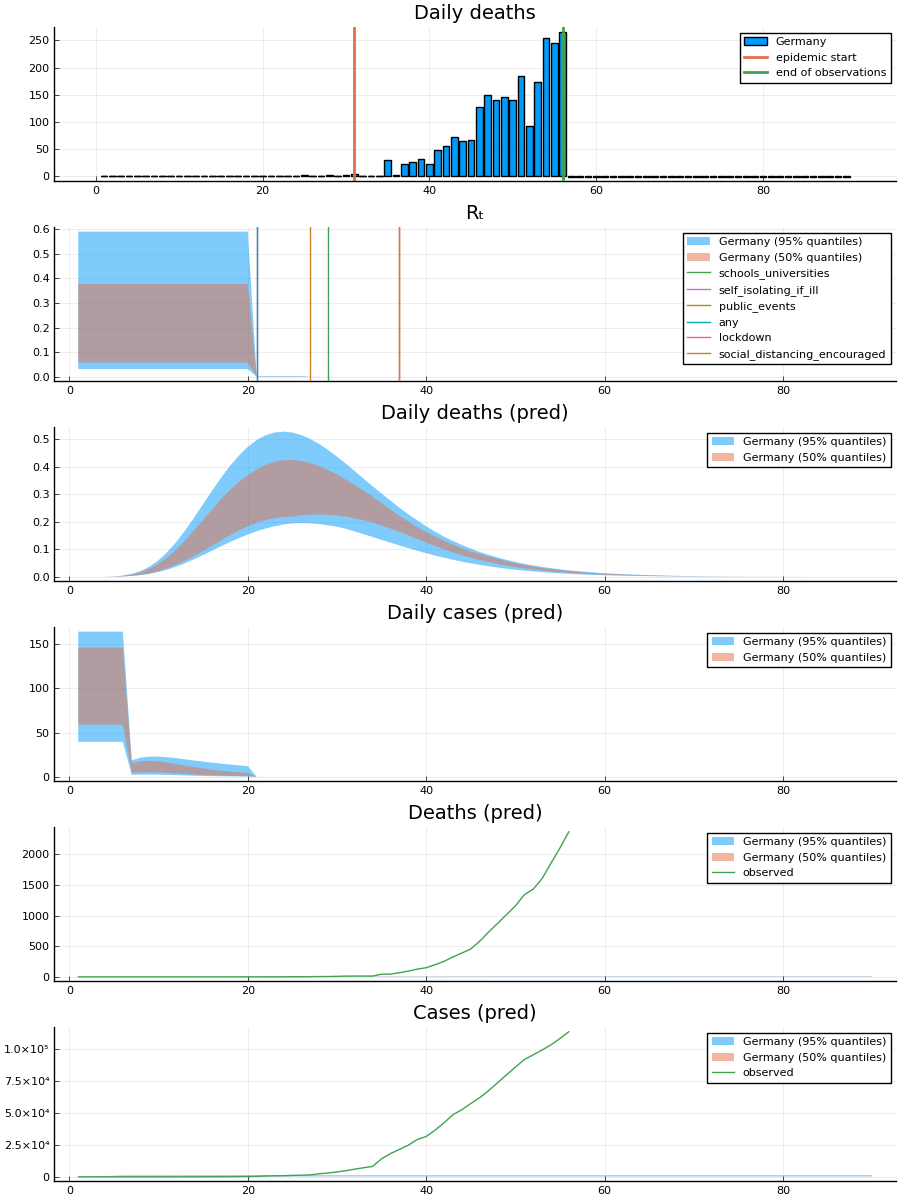

In [152]:
country_prediction_plot(3)

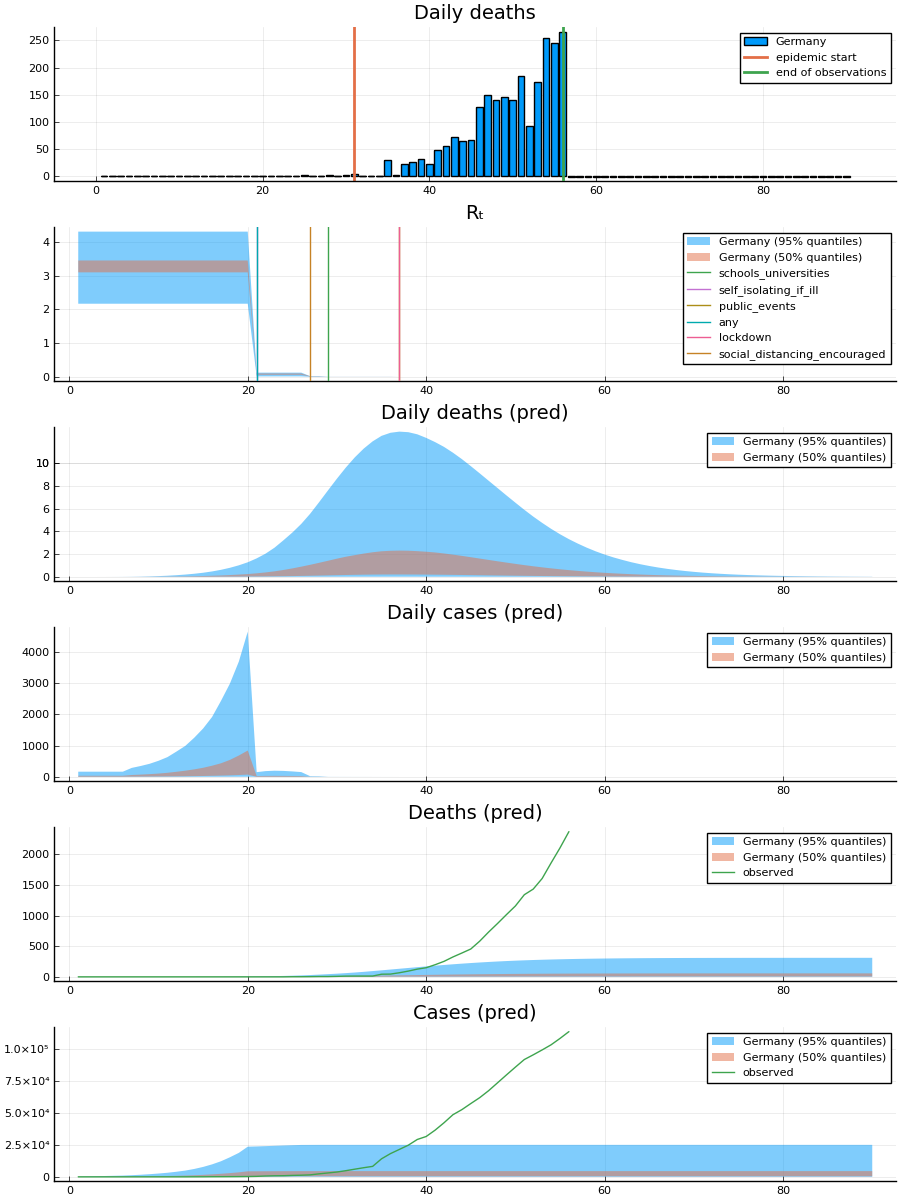

In [153]:
country_prediction_prior_plot(3)